# "Fine tuning" google's yamnet network to detect train sounds 

Accompanies the blog post here: 

This was a weekend project to track / quantify the train in my neighborhood that honks a lot. 
I eventually plan to correlate with my sleep patterns, but that's another day. 

As this was a short weekend project, no care has been take around clean code / bugs / proper validation dataset, etc.

### Some background
Google released yamnet: see https://github.com/tensorflow/models/tree/master/research/audioset/yamnet 
"YAMNet is a pretrained deep net that predicts 521 audio event classes based on the AudioSet-YouTube corpus, and employing the Mobilenet_v1 depthwise-separable convolution architecture."

The yamnet model does contain a 'train' and 'train horn' class, but found it was not accurate enough on my data. If your data is one of the 521 classes, you might be able to directly use the yamnet output and not train anything. 


This notebook takes the output feature vectors from yamnet as 1024 length vectors per patch of audio. We then feed those vectors into a small network that has been trained on the data I care about ( "train horn" vs "not train horn" ) 

I created a very small dataset of about 10 wavs per class -- where the "not train horn" class is just background noise, or noises that might be confused with a train horn ( dog bark, etc ) Each training sound is augmented a few times to create more data. 

Note: I did remove a few files from the data included here for file size reasons, but only 1-2 wav files. The accuracy here will be slightly lower than what I got. You can experiment with how much data is required for your task. 


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os 
import random
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [3]:
# sound libs, you don't really need all of them 
# librosa should suffice 
import soundfile as sf
import librosa
import resampy

## Clone the tf models repo 

 * NOTE: Large ~1GB download 

In [2]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
^Cceiving objects:  22% (7842/34112), 124.39 MiB | 217.00 KiB/s   


### Download the pre-trained weights for yamnet model

In [4]:

!wget https://storage.googleapis.com/audioset/yamnet.h5

--2020-02-04 15:29:59--  https://storage.googleapis.com/audioset/yamnet.h5
Resolving storage.googleapis.com... 216.58.194.144
Connecting to storage.googleapis.com|216.58.194.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15296092 (15M) [application/octet-stream]
Saving to: ‘yamnet.h5’

yamnet.h5           100%[===================>]  14.59M  1.11MB/s    in 18s     

2020-02-04 15:30:18 (814 KB/s) - ‘yamnet.h5’ saved [15296092/15296092]



In [4]:
## add yamnet to sys path 
yamnet_base = './models/research/audioset/yamnet/'
sys.path.append(yamnet_base)

In [5]:
## Yamnet imports 
import params
import yamnet as yamnet_tf
import modified_yamnet as yamnet


import features as features_lib

In [6]:
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
print("tf version: ", tf.__version__)
print("tf.keras version: ", tf.keras.__version__)

tf version:  2.0.0
tf.keras version:  2.2.4-tf


In [9]:
DESIRED_SR = 16000
NUM_CLASSES = 2 # ( other, train)

# Set up the YAMNet model.
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.

yamnet_model, dense_net = yamnet.yamnet_frames_model(params)

yamnet_model.load_weights('yamnet.h5')

class_names = yamnet_tf.class_names(os.path.join(yamnet_base, 'yamnet_class_map.csv'))

## Some helper functions for later

In [10]:
def read_wav(fname, output_sr, use_rosa=True):
    # small wrapper - i was seeing some slightly different 
    # results when loading with different libraries 
    if use_rosa:
        waveform, sr = librosa.load(fname, sr=output_sr)
    else:
        wav_data, sr = sf.read(fname, dtype=np.int16)
        
        if wav_data.ndim > 1: 
            # (ns, 2)
            wav_data = wav_data.mean(1)
        if sr != output_sr:
            wav_data = resampy.resample(wav_data, sr, output_sr)
        waveform = wav_data / 32768.0
    
    return waveform.astype(np.float64)


In [11]:
def remove_silence(waveform, top_db=15, min_chunk_size=2000, merge_chunks=True):
    # Loads sample into chunks of non-silence 
    
    splits = librosa.effects.split(waveform, top_db=top_db)
    
    waves = []
    for start, end in splits:
        if (end-start) < min_chunk_size:
            continue
        waves.append(waveform[start:end])
    
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                out = np.concatenate((out, c))
        waves = out
    
    return waves


In [12]:
def get_top_dirs(p):
    dirs = list(filter(lambda x : os.path.isdir( os.path.join(p, x) ), os.listdir(p)))
    return list(map(lambda x : os.path.join(p, x), dirs))

In [13]:
def random_augment_wav(wav_data):
    # apply some random augmentations to the sound
    # - time stretch, resample, volume change, minor noise 
    # - this has not been evaluated to measure contributions
    # - TODO: probably a lot more augmentations you could use 
    
    wav_data = wav_data.copy() 
    
    # random re-sample 
    if np.random.uniform() > 0.8:
        stretch = np.random.uniform(0.75, 1.5)
        wav_data = librosa.effects.time_stretch(wav_data, stretch)
    elif np.random.uniform() > 0.2:
        new_sr = int(DESIRED_SR * np.random.uniform(0.9, 1.1))
        wav_data = resampy.resample(wav_data, DESIRED_SR, new_sr)
    
    #librosa.effects.pitch_shift()
    
    # random volume
    volume = np.random.uniform(0.65, 1.2)
    wav_data = wav_data * volume
    
    # Random noise
    if np.random.uniform() > 0.5:
        NR = 0.001 # 0.1
        wav_data += np.random.uniform(-NR, NR, size=wav_data.shape)
    
    return wav_data
    
    

In [14]:
def load_data(base_path, 
              audio_model, 
              num_augmentations=5,
              max_sample_seconds=5.0,
              use_rosa=True):
    """
    Loads data from .wav files contained in subfolders where 
    folder name is label, then runs them 
    through the audio_model to get feature vectors 
    and returns:
    
    X : [ np.array(1024) , ... ]
    Y : [ category_idx , ...]
    
    """
    
    label_dirs = get_top_dirs(base_path)
    
    _samples = []
    _labels = []
    
    merge_chunks = True
    MIN_WAV_SIZE = 5000 # TODO: seems to need to be pretty long for NN to work?
    max_wav_size = int(DESIRED_SR * max_sample_seconds)
    
    for label_idx, label_dir in enumerate(label_dirs):
        
        label_name = os.path.basename(label_dir)
        wavs = glob.glob(os.path.join(label_dir, "*.wav"))
        print(" Loading {:<5} '{:<40}'".format(label_idx, label_name))
        
        for wav_file in tqdm(wavs):
            
            # rosa seems very different?
            #for use_rosa in range(2):
            if True:
                #use_rosa = 1
                #use_rosa = np.random.uniform() > 0.5
                waveform = read_wav(wav_file, DESIRED_SR, use_rosa=use_rosa)

                if label_name == 'train':
                    waveform = remove_silence(waveform)

                if len(waveform) < MIN_WAV_SIZE:
                    continue 

                if len(waveform) > max_wav_size:
                    waveform = waveform[:max_wav_size]

                for aug_idx in range(1 + num_augmentations):
                    
                    aug_wav = waveform.copy()
                    
                    if aug_idx > 0:
                        aug_wav = random_augment_wav(aug_wav)

                    _, _, dense_out, _ = audio_model.predict(np.reshape(aug_wav, [1, -1]), steps=1)
                    
                    for patch in dense_out:
                        _samples.append(patch)
                        _labels.append(label_idx)
                
    return _samples, _labels
    

Text(0.5, 1.0, 'Sample Train Sound')

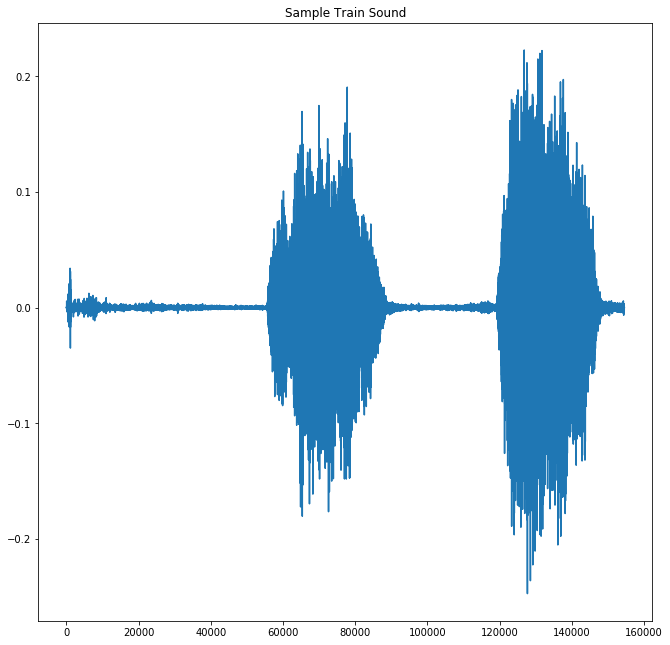

In [15]:
## Plot a wave file 

fname = "training_data/train/train_15.wav"

waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

figure(figsize=(11,11))

plot(waveform)
title("Sample Train Sound")


### Plot Yamnet predictions on our data

In [16]:
# Run the model.
scores, spectrogram, dense_out, patches = yamnet_model.predict(np.reshape(waveform, [1, -1]), steps=1)

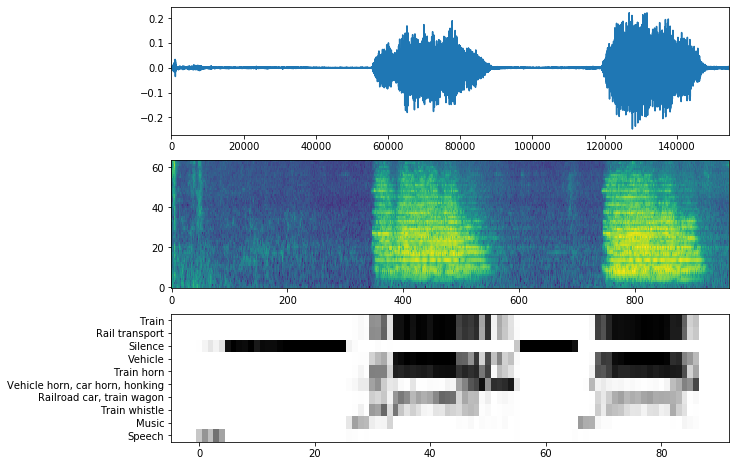

In [17]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

In [18]:
## Load our training data

In [19]:
samples, labels = load_data("training_data",
                            yamnet_model,
                            num_augmentations=4, 
                            max_sample_seconds=10.0)


  0%|          | 0/4 [00:00<?, ?it/s]

 Loading 0     'not_train                               '


  0%|          | 0/7 [00:00<?, ?it/s]

 Loading 1     'train                                   '


100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


In [20]:
idxs = list(range(len(labels)))
random.shuffle(idxs)

samples = [samples[i] for i in idxs]
labels = [labels[i] for i in idxs]

samples = np.array(samples)
labels = np.array(labels)

print(" Loaded samples: " , samples.shape, samples.dtype,  labels.shape)


 Loaded samples:  (1381, 1024) float32 (1381,)


## Create our 'fine tuning' thin model that accepts yamnet feature vector outputs 

You can play with how many layers, or which activation functions to use, etc

In [21]:
def get_top_model(num_classes=3, 
                  input_size=1024,
                  num_hidden=1024):

    input_layer = layers.Input(shape=(input_size,))
    
    output = layers.Dense(num_hidden, activation=None)(input_layer)
    
    output = layers.Dense(num_classes, activation='softmax')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model


In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [23]:
num_hidden = 1024
feature_len = 1024

model = get_top_model(num_classes=NUM_CLASSES, 
                      input_size=feature_len, 
                      num_hidden=num_hidden)

#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Train the model 
history = model.fit(samples, labels, epochs=200, validation_split=0.123)

Train on 1211 samples, validate on 170 samples
Epoch 1/200
1211/1211 [==============================] - 1s 568us/sample - loss: 0.1988 - accuracy: 0.9315 - val_loss: 0.0385 - val_accuracy: 1.0000
Epoch 2/200
1211/1211 [==============================] - 0s 131us/sample - loss: 0.0305 - accuracy: 0.9983 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 3/200
1211/1211 [==============================] - 0s 191us/sample - loss: 0.0207 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 4/200
1211/1211 [==============================] - 0s 162us/sample - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 5/200
1211/1211 [==============================] - 0s 153us/sample - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 6/200
1211/1211 [==============================] - 0s 180us/sample - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 7/200
1211/1211 [==============================] - 0s

1211/1211 [==============================] - 0s 132us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 56/200
1211/1211 [==============================] - 0s 185us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 57/200
1211/1211 [==============================] - 0s 139us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 58/200
1211/1211 [==============================] - 0s 179us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 59/200
1211/1211 [==============================] - 0s 131us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 60/200
1211/1211 [==============================] - 0s 126us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 61/200
1211/1211 [==============================] - 0s 191us/sample - loss: 0.0013 - accuracy: 1.0000 - val

Epoch 109/200
1211/1211 [==============================] - 0s 174us/sample - loss: 6.9731e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 110/200
1211/1211 [==============================] - 0s 147us/sample - loss: 6.9111e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 111/200
1211/1211 [==============================] - 0s 171us/sample - loss: 6.8452e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 112/200
1211/1211 [==============================] - 0s 136us/sample - loss: 6.7855e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 113/200
1211/1211 [==============================] - 0s 137us/sample - loss: 6.7208e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 114/200
1211/1211 [==============================] - 0s 189us/sample - loss: 6.6619e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 115/200
1211/1211 [==============================] - 0s 135us/sa

Epoch 161/200
1211/1211 [==============================] - 0s 132us/sample - loss: 4.6789e-04 - accuracy: 1.0000 - val_loss: 8.2279e-04 - val_accuracy: 1.0000
Epoch 162/200
1211/1211 [==============================] - 0s 142us/sample - loss: 4.6493e-04 - accuracy: 1.0000 - val_loss: 8.1833e-04 - val_accuracy: 1.0000
Epoch 163/200
1211/1211 [==============================] - 0s 170us/sample - loss: 4.6207e-04 - accuracy: 1.0000 - val_loss: 8.1511e-04 - val_accuracy: 1.0000
Epoch 164/200
1211/1211 [==============================] - 0s 133us/sample - loss: 4.5907e-04 - accuracy: 1.0000 - val_loss: 8.1201e-04 - val_accuracy: 1.0000
Epoch 165/200
1211/1211 [==============================] - 0s 131us/sample - loss: 4.5620e-04 - accuracy: 1.0000 - val_loss: 8.0767e-04 - val_accuracy: 1.0000
Epoch 166/200
1211/1211 [==============================] - 0s 171us/sample - loss: 4.5343e-04 - accuracy: 1.0000 - val_loss: 8.0368e-04 - val_accuracy: 1.0000
Epoch 167/200
1211/1211 [=====================

In [25]:
# a few iterations on all the data
history = model.fit(samples, labels, epochs=5)

Train on 1381 samples
Epoch 1/5
1381/1381 [==============================] - 0s 161us/sample - loss: 4.1259e-04 - accuracy: 1.0000
Epoch 2/5
1381/1381 [==============================] - 0s 183us/sample - loss: 4.0993e-04 - accuracy: 1.0000
Epoch 3/5
1381/1381 [==============================] - 0s 128us/sample - loss: 4.0705e-04 - accuracy: 1.0000
Epoch 4/5
1381/1381 [==============================] - 0s 119us/sample - loss: 4.0439e-04 - accuracy: 1.0000
Epoch 5/5
1381/1381 [==============================] - 0s 140us/sample - loss: 4.0171e-04 - accuracy: 1.0000


## Test on a holdout sound 

In [26]:
def run_models(waveform, 
               yamnet_model, 
               top_model, 
               strip_silence=True, 
               min_samples=16000):
    
    if strip_silence:
        waveform = remove_silence(waveform, top_db=10)
    
    if len(waveform) < min_samples:
        print("input too short after silence removal")
        return None
    
    _, _, dense_out, _ = \
        yamnet_model.predict(np.reshape(waveform, [1, -1]), steps=1)
    
    # dense = (N, 1024)
    all_scores = []
    for patch in dense_out:
        scores = model.predict( np.expand_dims(patch,0)).squeeze()
        all_scores.append(scores)
        
    all_scores = np.mean(all_scores, axis=0)
    return all_scores


In [27]:
categories = ["not train", "train"]

In [28]:
fname = "holdout_train_sounds/train2.wav"
waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

#waveform = remove_silence(waveform, top_db=10)

# make file a bit longer by duplicating it 
waveform = np.concatenate((waveform,waveform,waveform,waveform))

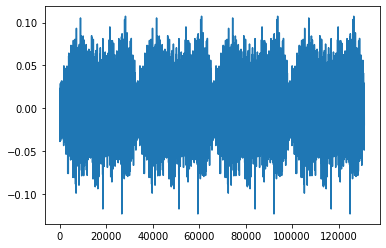

In [29]:
plot(waveform)

In [31]:
scores = run_models(waveform, yamnet_model, model)
winner = categories[scores.argmax()]

print(" Best score: {}  label: {}".format(scores.max(), winner))


 Best score: 0.9999927878379822  label: train


In [32]:
## Save the model for later
model.save("top_model.h5", include_optimizer=False)

In [33]:
# NOTE: PyAudio required here 
# device index from pyaudio 
!python classify_from_mic.py 0

 --- Using input device:  0
2020-02-04 16:51:51.503589: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-02-04 16:51:51.520644: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feccf326a80 executing computations on platform Host. Devices:
2020-02-04 16:51:51.520666: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
{'index': 0, 'structVersion': 2, 'name': 'Built-in Microphone', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.0029478458049886623, 'defaultLowOutputLatency': 0.01, 'defaultHighInputLatency': 0.01310657596371882, 'defaultHighOutputLatency': 0.1, 'defaultSampleRate': 44100.0}
_______
{'index': 1, 'structVersion': 2, 'name': 'Built-in Output', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.003877